# BBC News Classification Kaggle Mini-Project

https://www.kaggle.com/c/learn-ai-bbc/overview

## 1) Objectives

This Kaggle competition is about categorizing news articles. You will use matrix factorization to predict the category and submit your notebook for peer evaluation. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

The competition is evaluated using Accuracy as a metric.

### Description

Text documents are one of the richest sources of data for businesses. We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

Following blog has good information on how to look at the problem. https://cloud.google.com/blog/products/gcp/problem-solving-with-ml-automatic-document-classification

### Dataset Description

The dataset is broken into 1490 records for training and 735 for testing.

- **BBC News Train.csv** - the training set of 1490 records
- **BBC News Test.csv** - the test set of 736 records
- **BBC News Sample Solution.csv** - a sample submission file in the correct format
_fields_
- **ArticleId** - Article id unique # given to the record
- **Article** - text of the header and article
- **Category** - cateogry of the article (tech, business, sport, entertainment, politics

## 2) Project Setup

In [1]:
# System stuff
import os
import sys
from pathlib import Path

# Basic data science
import random
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm

import kagglehub   # need this to download dataset

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

# Scikit-learn (including 3 or 4 that I didn't end up keeping in the final code.
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_selection import chi2
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from wordcloud import WordCloud
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay,
    mean_squared_error, mean_absolute_error, r2_score,
    f1_score, accuracy_score, precision_score, recall_score, silhouette_score
)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Plotting defaults
sns.set_theme(context="notebook", style="darkgrid", palette="deep")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 120,
    "axes.titlesize": 14,
    "axes.labelsize": 12
})
# helper function to delimit sections in data output
def section_split(width=200, char="-"):
    print("\n", char * width, "\n")

# helper function to save figures
def save_figure(name=None, dpi=300, bbox_inches='tight', pad_inches=0.1):
    # Create directory if it doesn't exist
    save_dir = "figs/5510_mini_project"
    os.makedirs(save_dir, exist_ok=True)
    # Generate filename
    if name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"chart_{timestamp}.png"
    else:
        # Clean the name to be filename-safe
        filename = "".join(c for c in name if c.isalnum() or c in (' ', '-', '_')).rstrip()
        filename = filename.replace(' ', '_')
        if not filename.endswith('.png'):
            filename += '.png'
    # Full path
    filepath = os.path.join(save_dir, filename)
    # Save the figure
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches, pad_inches=pad_inches)
    print(f"Figure saved: {filepath}")
    return filepath

print("Python:", sys.version.split()[0])
print("Pandas:", pd.__version__)

Python: 3.11.13
Pandas: 2.3.2


In [2]:
## Load the csv files downloaded from the Kaggle Competition page via the api.
sample_solution = pd.read_csv('data/learn-ai-bbc/BBC News Sample Solution.csv', sep = ',')
test = pd.read_csv('data/learn-ai-bbc/BBC News Test.csv', sep = ',')
train = pd.read_csv('data/learn-ai-bbc/BBC News Train.csv', sep = ',')
display(train)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


## 3) Exploratory Data Analysis
Note: I will start with the initial analyses provided in the referenced article: Problem-solving with ML: automatic document classification (see above).
- Basic distribution across classes/categories
- tf-idf and use of chi-squared to find unigrams/bigrams
- t-SNE (a dimensionality reduction technique) to plot initial clusters

Just these analyses show us that we have a balanced training dataset, the words and bigrams that correlate best with the categories make sense and the resulting clusters of documents by category are well separated with few outliers.

In [3]:
# Absolute basic checks
print(f'train shape: {train.shape}, test shape: {test.shape}')
print(f'train columns: {train.columns}')
print(f'test columns: {test.columns}')
section_split(width=100)
print(f'Check for duplicates:\n{train.duplicated().sum()}')
print(f'Check for NaNs:\n{train.isna().sum()}\nCheck for nulls:\n{train.isnull().sum()}')

train shape: (1490, 3), test shape: (735, 2)
train columns: Index(['ArticleId', 'Text', 'Category'], dtype='object')
test columns: Index(['ArticleId', 'Text'], dtype='object')

 ---------------------------------------------------------------------------------------------------- 

Check for duplicates:
0
Check for NaNs:
ArticleId    0
Text         0
Category     0
dtype: int64
Check for nulls:
ArticleId    0
Text         0
Category     0
dtype: int64


In [4]:
# first add a CategoryID column to the train set and create dictionaries for lookup
category_ids = train.Category.factorize()
train['CategoryID'] = category_ids[0]
category_to_id = {}
id_to_category = {}
for i, category in enumerate(category_ids[1]):
    category_to_id[category] = i
    id_to_category[i] = category

Figure saved: figs/5510_mini_project/articles_by_category.png


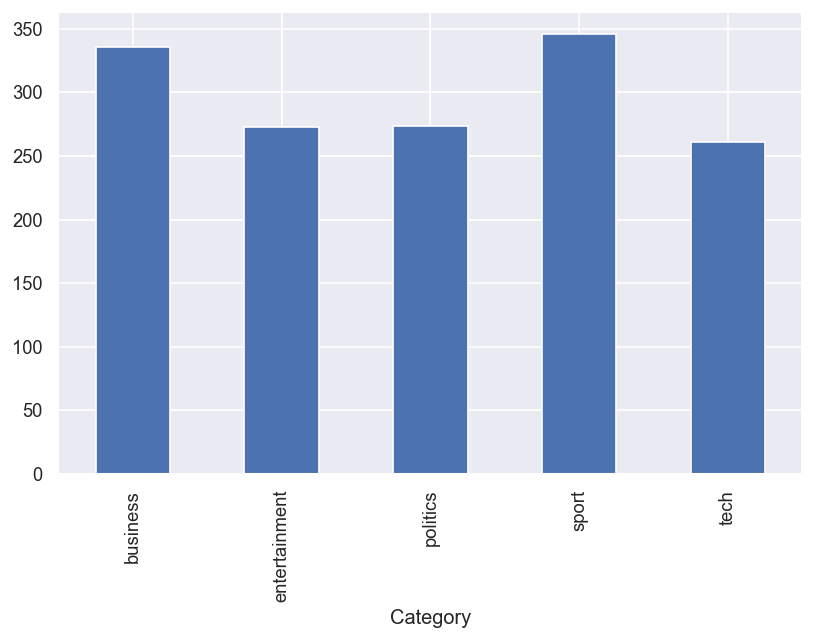

In [5]:
# Check distribution of articles by category
train.groupby('Category').ArticleId.count().plot.bar(ylim=0)
save_figure("articles_by_category")
plt.show()

In [6]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        min_df=5,
                        norm='l2',
                        ngram_range=(1, 2),
                        stop_words='english')

features = tfidf.fit_transform(train['Text'])
feature_names = tfidf.get_feature_names_out()
labels = train.CategoryID
print(f'After tf-idf vectorisation we have a matrix of (articles, features) {features.shape}')
print(f"Feature names length: {len(feature_names)}")

test_features = tfidf.transform(test['Text']).toarray()



After tf-idf vectorisation we have a matrix of (articles, features) (1490, 9927)
Feature names length: 9927


In [7]:
N = 3 # num unigrams/bigrams to show per category
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  names_array = np.array(feature_names)[indices]
  unigrams = [v for v in names_array if len(v.split(' ')) == 1]
  bigrams = [v for v in names_array if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'business':
  . Most correlated unigrams:
       . growth
       . bank
       . shares
  . Most correlated bigrams:
       . stock market
       . economic growth
       . analysts said
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . won best
       . los angeles
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . match
       . coach
       . cup
  . Most correlated bigrams:
       . grand slam
       . champions league
       . australian open
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


### Enhancing EDA with word clouds
The initial tf-idf and chi-squared correlations produce a nice simple listing of the most important unigrams and bigrams in the dataset. However, it is not yielding a good feel for the word characteristics of each topic. Using word clouds could give a quick visual intuition of the data characteristics.

My thanks to Farzat on Kaggle: https://www.kaggle.com/code/farzat/bbc-news-classification-kaggle-mini-project for the starter code here. I took it a step further by creating clouds per category to allow comparison.

Figure saved: figs/5510_mini_project/word_clouds_initial_tfidf.png


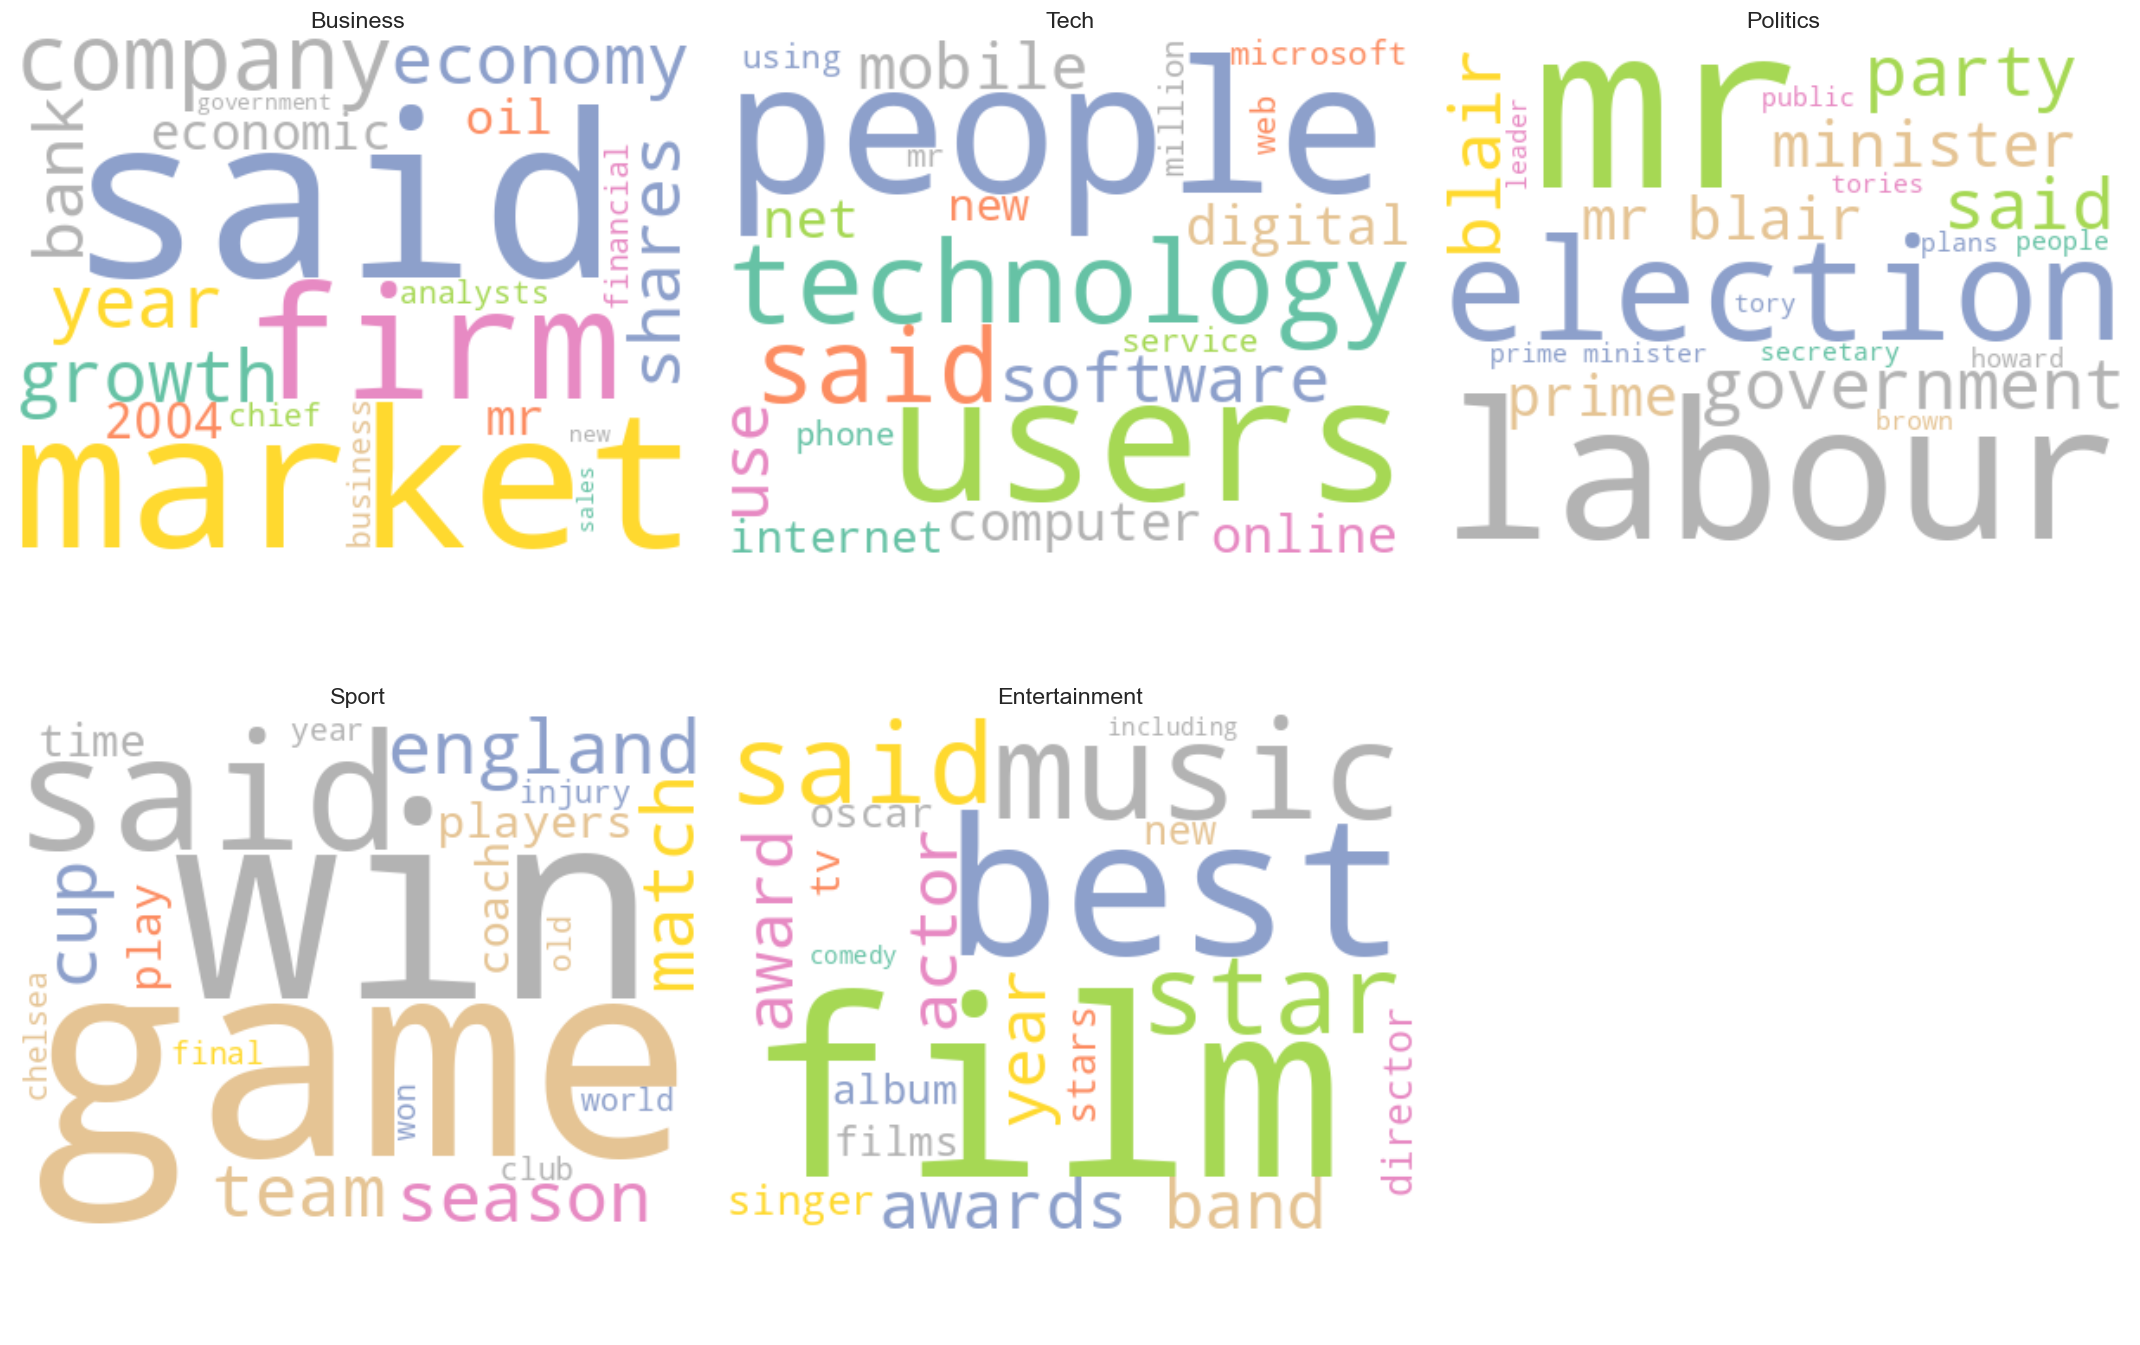

In [8]:
def plot_word_clouds(features, feature_names, num_words=20, filename="word_clouds"):

    # Get top TF-IDF words for each category
    category_word_scores = {}

    for category, category_id in category_to_id.items():
        # Get TF-IDF scores for this category
        category_mask = train['CategoryID'] == category_id
        category_features = features[category_mask]
        # Calculate mean TF-IDF score for each word in this category
        mean_scores = np.array(category_features.mean(axis=0)).flatten()
        # Get top words by TF-IDF score
        top_indices = mean_scores.argsort()[-num_words:][::-1]  # Top num_words in descending order
        top_words_tfidf = []
        for idx in top_indices:
            word = feature_names[idx]
            score = mean_scores[idx]
            top_words_tfidf.append((word, score))

        category_word_scores[category] = top_words_tfidf

    # Create word clouds from TF-IDF scores
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, (category, word_scores) in enumerate(category_word_scores.items()):
        if i < len(axes):
            # Create word frequency dictionary (use TF-IDF scores as weights)
            word_freq = {word: score*1000 for word, score in word_scores}  # Scale scores

            # Generate word cloud
            wordcloud = WordCloud(
                width=400,
                height=300,
                background_color='white',
                max_words=50,
                colormap='Set2',
                prefer_horizontal=0.7
            ).generate_from_frequencies(word_freq)
            # Plot
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'{category.capitalize()}')
            axes[i].axis('off')

    # Hide unused subplot
    if len(category_word_scores) < len(axes):
        axes[-1].axis('off')

    plt.tight_layout()
    save_figure(filename)
    plt.show()
    return

plot_word_clouds(features, feature_names,filename="word_clouds_initial_tfidf")

From the word clouds generated per category, it is clear that although the majority of the words clearly align with the category, there are also a number of neutral words that are appearing in our characterizations (e.g. said, mr, year, time, ...). Maybe our search for clusters would become more meaningful if we trimmed out such neutral words as part of tf-idf vectorization.

I asked AI to generate a list of such words: see custom_stop_words below. Then edited the list manually.

It might make sense to introduce lemmas here as well. Based on what I saw from others on the Kaggle site, it didn't actually yield much and added complexity to the implementation and results interpretation. Therefore, I decided not to do so.

In an attempt to improve the results, I also tried adjusting the parameters of the tf-idf vectorizer. I'm sure that there is more that could be done here, but these values seemed to work well enough.
After these adjustments the word clouds look more meaningful.

Figure saved: figs/5510_mini_project/word_clouds_improved_tfidf.png


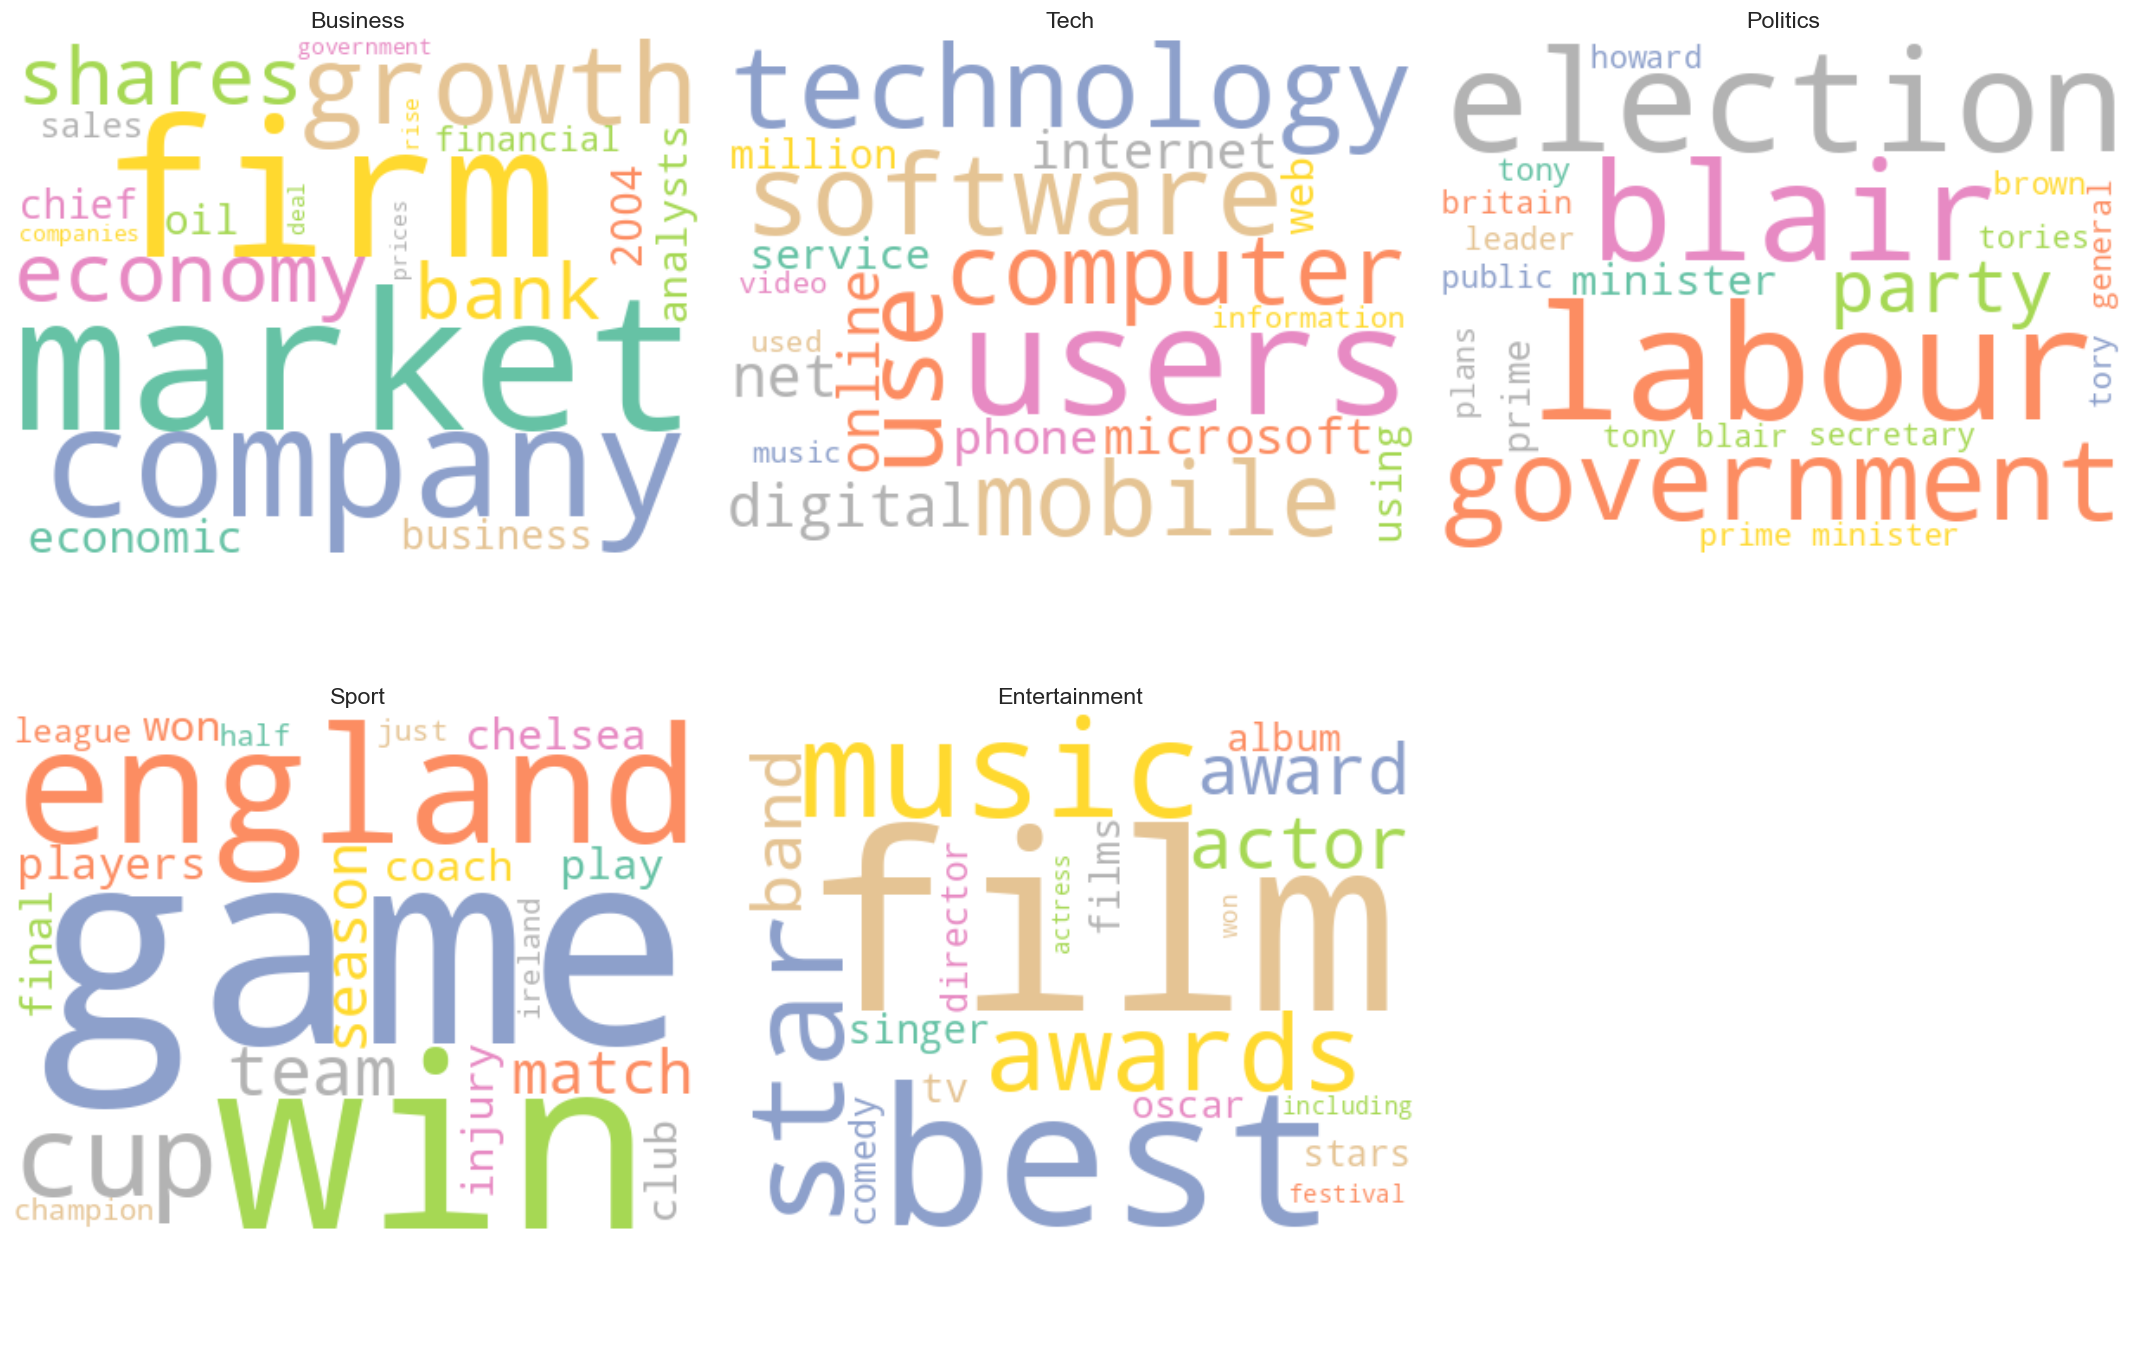

In [9]:
# Add domain-specific stop words that you've identified
custom_stop_words = set(ENGLISH_STOP_WORDS) | {
    'said', 'says', 'say', 'told', 'tells', 'tell',  # Reporting verbs
    'mr', 'mrs', 'ms', 'dr',  # Titles
    'one', 'two', 'three', 'first', 'second',  # Numbers/ordinals
    'year', 'years', 'month', 'months', 'day', 'days',  # Generic time
    'also', 'would', 'could', 'should', 'may', 'might',  # Modal verbs
    'new', 'old', 'good', 'bad', 'big', 'small',  # Generic adjectives
    'people', 'person', 'man', 'woman', 'men', 'women',  # Generic people
    'time', 'way', 'country', 'world'  # Very general terms
}
# from debugging tfidf only accepts a list not a set
if isinstance(custom_stop_words, set):
    custom_stop_words = list(custom_stop_words)

# Create improved TF-IDF vectorizer
tfidf_improved = TfidfVectorizer(
    sublinear_tf=True,
    stop_words=custom_stop_words,
    min_df=3,  # Appear in at least 3 documents
    max_df=0.7,  # Appear in at most 70% of documents
    ngram_range=(1, 2),
    max_features=None,  #might come back to this one later, depending on NMF results
    lowercase=True,
    strip_accents='unicode'
)

features = tfidf_improved.fit_transform(train['Text'])
feature_names = tfidf_improved.get_feature_names_out()

plot_word_clouds(features, feature_names, filename="word_clouds_improved_tfidf")

The next step is to see if we have any kind of obviousl clustering in the data (the word clouds suggest so). Using the TSNE function from sklearn, as suggested in the referenced article above.

From the sklearn documentation: TSNE = T-distributed Stochastic Neighbor Embedding. t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

Figure saved: figs/5510_mini_project/tfidf_feature_vectors.png


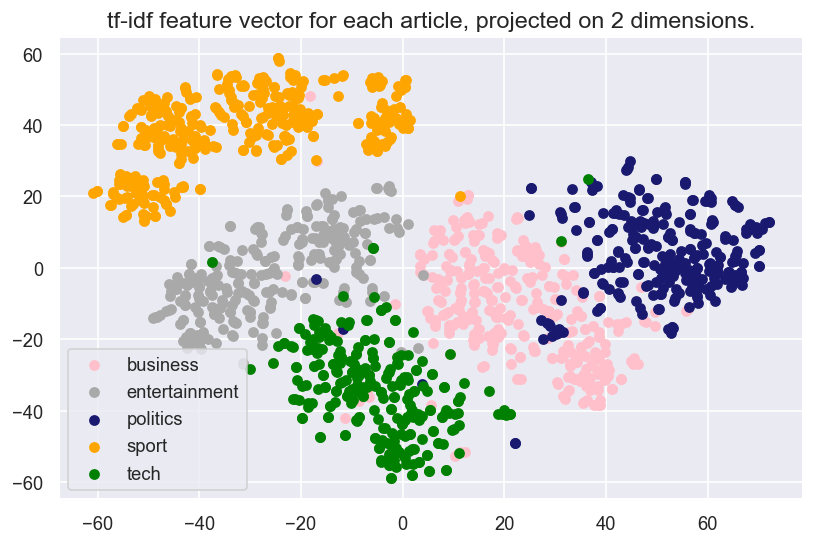

In [10]:
# use t-SNE to plot the tf-idf feature vectors for each article
# Allow sampling a subset of our dataset because t-SNE is computationally expensive
# for now sample = 100% of dataset
f_array = features.toarray()
num_features = len(f_array)
SAMPLE_SIZE = int(num_features * 1)
indices = np.random.choice(range(num_features), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=SEED).fit_transform(f_array[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.")
plt.legend()
save_figure("tfidf_feature_vectors")
plt.show()

It is clear from the TSNE plot that we have nice clear topic/category clusters. There are a few outliers, the separation is not perfect and nor should we expect it to be in this type of topic extraction analysis. There are bound to be confusions such as a business article about the finances of a football club, or a politician making an economic evaluation in business terms.

As we evaluate the results, it may be useful to look at what the model gets wrong to see if there is a textual explanation and if it warrants adjustment in our pre-processing.

As a baseline, it looks good enough to set up the data for modelling with train_test_split etc.

In [11]:
# to support predictions on the test set
test_features = tfidf_improved.transform(test['Text']).toarray()

# As the provided test set has no category labels, we will need to split the training set further to understand the results of our models better.
# % of the training set for testing.
test_size = 0.3
# We need the indices of the training and test sets to use them later when plotting the results.
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features,
                                                                                 labels,
                                                                                 train.index,
                                                                                 test_size=test_size,
                                                                                 random_state=SEED)

## 4) A Supervised Learning Approach

Again, making heavy use of the referenced article, as the objective of this mini-project is to learn about Matrix Factorisation not to optimise supervised learning. In the article, LogisticRegression provided the best accuracy, beating Random Forest Classification and MultinomialNB. I will take that as the starting point.

The LogisticRegression result is a model with high accuracy 97.5%. Examining the miss-classifications from the confusion matrix clarifies the reason for errors. In each example, there are words/bigrams that have high correlation with an alternative category. For example: a business article about mobile phones (2 of the most correlated bigrams with tech).

Validation scores for LogisticRegression
Accuracy: 0.975 +/- 0.005 on entire training set

Classification Report:
               precision    recall  f1-score   support

     business       0.98      0.96      0.97       108
         tech       0.95      0.96      0.95        73
     politics       0.97      0.97      0.97        86
        sport       0.99      1.00      1.00       101
entertainment       1.00      1.00      1.00        79

     accuracy                           0.98       447
    macro avg       0.98      0.98      0.98       447
 weighted avg       0.98      0.98      0.98       447

Figure saved: figs/5510_mini_project/logisticregression_confusion_matrix.png


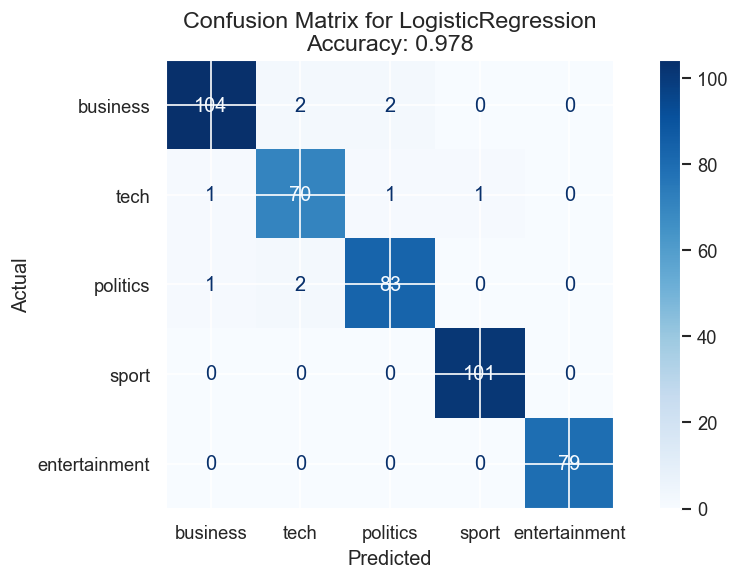


Misclassified articles per category, more than one example:

'business' predicted as 'tech' : 2 examples.

Article 1384 (Category: business):
brussels raps mobile call charges the european commission has written to the mobile phone operators vodafone and t-mobile to challenge  the high rates  they charge for international roaming.  in letters sent to the two companies  the commission alleged the firms were abusing their dominant market po
--------------------------------------------------------------------------------

Article 664 (Category: business):
orange colour clash set for court a row over the colour orange could hit the courts after mobile phone giant orange launched action against a new mobile venture from easyjet s founder.  orange said it was starting proceedings against the easymobile service for trademark infringement. easymobile uses
--------------------------------------------------------------------------------
'politics' predicted as 'tech' : 2 examples.

Article 1415

,ArticleId,Text,Predicted_Category LR
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport


In [12]:
cv = 3
scoring = 'accuracy'
LR_model = LogisticRegression(random_state=SEED)
LR_model.fit(features, labels)
accuracies = cross_val_score(LR_model, features, labels, scoring=scoring, cv=cv)
print(f"Validation scores for LogisticRegression\nAccuracy: {accuracies.mean():.3f} +/- {accuracies.std():.3f} on entire training set")

LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)


def plot_confusion(y_test, y_pred, name='model', verbose=True):
    if verbose:
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=list(id_to_category.values())))
    conf_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    fig_title = f"Confusion Matrix for {name}\nAccuracy: {accuracy:.3f}"
    disp = ConfusionMatrixDisplay(conf_mat, display_labels=list(id_to_category.values()))
    disp.plot(cmap='Blues')
    disp.ax_.set_title(fig_title)
    disp.ax_.set_xlabel("Predicted")
    disp.ax_.set_ylabel("Actual")
    plt.tight_layout()
    save_figure(name.lower()+"_confusion_matrix")
    plt.show()
    if verbose:
        print("\nMisclassified articles per category, more than one example:\n")
        for predicted in list(id_to_category.keys()):
            for actual in list(id_to_category.keys()):
                if predicted != actual and conf_mat[actual, predicted] >= 2:
                    print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
                    mask = (y_test == actual) & (y_pred == predicted)
                    misclassified_indices = indices_test[mask]
                    for idx in misclassified_indices:
                        print(f"\nArticle {idx} (Category: {train.loc[idx]['Category']}):")
                        print(train.loc[idx]['Text'][:300]
        )
                        print("-" * 80)
    return accuracy

accuracy_logistic_regression = plot_confusion(y_test, y_pred, name='LogisticRegression')

# Predict on the actual test data
test_predictions = LR_model.predict(test_features)
test['Predicted_Category LR'] = [id_to_category[pred] for pred in test_predictions]
print("\nTest predictions:")
display(test.head())


## 5) Matrix Factorisation to Predict Category
- Approach One = Create a pipeline where NMF (Non-Negative Matrix Factorisation) is used for **dimensionality reduction** then Logistic Regression used as classifier. I chose this option based on what I read on Kaggle and my internet research. However, I don't think it fits that well with the objective of this mini-project.
- Approach Two = Use NMF for **direct topic extraction**. This seems closer to what we were asked to do.

### Approach One - NMF for Dimensionality Reduction

Figure saved: figs/5510_mini_project/nmf_one_confusion_matrix.png


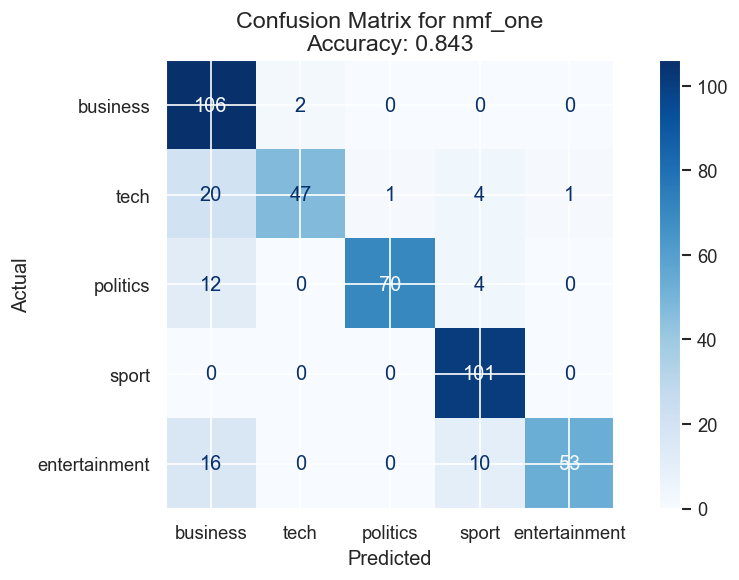


Test predictions:


,ArticleId,Text,Predicted_Category LR,Predicted_Category NMF one
0,1018,qpr keeper day heads for preston queens park r...,sport,sport
1,1319,software watching while you work software that...,tech,business
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport,sport
3,459,india s reliance family feud heats up the ongo...,business,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport,sport


In [13]:
# Create and train NMF classifier
nmf_one = Pipeline([
    ('nmf', NMF(n_components=50, random_state=SEED)),
    ('classifier', LogisticRegression(random_state=SEED, max_iter=1000))
])

nmf_one.fit(X_train, y_train)
y_pred_nmf = nmf_one.predict(X_test)

accuracy_nmf_one = plot_confusion(y_test, y_pred_nmf, name='nmf_one', verbose=False)

# Predict on the actual test data
test_predictions = nmf_one.predict(test_features)
test['Predicted_Category NMF one'] = [id_to_category[pred] for pred in test_predictions]
print("\nTest predictions:")
display(test.head())

The results of Approach One are considerably worse than achieved with Logistic Regression. Potentially, I could drive improvement with parameter tuning, but first let's look at option 2.

### Approach Two - NMF for topic extraction

**Choosing n_topics**

I spent quite a bit of time iterating through different choices for n_topics. It doesn't have to be set to 5 just because we know the training data has five defined categories. NMF is an unsupervised learning technique, and it can be interesting to see what topics it finds in the data. Maybe there are subtopics to the requested categories that are interesting and/or provide a better input to classification.

However, what I found was:
1) 10 clouds offered little improvement in classification or interpretability that I could determine
2) When I tried explicitly tuning n_components as a hyper-parameter, there was no clear elbow in the resulting plots of n_components between 2 and 30 (see analysis below)
3) 5 topics still seems a good balance between simplicity, interpretability and classification accuracy.

**The other hyperparameters**

Selecting the right hyperparameters proved to be a bit of a challenge.
1) max_iter < 1000 often led to warnings during execution and tuning
2) alpha_W and alpha_H were difficult to interpret, any value > 0.001 yielded zeros in all weightings for the word listings. In the end I opted for no regularisation.
3) init='nndsvd' was the only one that worked reliably.
4) solver = 'cd', is the default. I didn't try 'mu' given the results seemed good enough with cd.

In [14]:
# Apply NMF for topic extraction
n_topics = 5
nmf_model = NMF(
    n_components=n_topics,
    random_state=SEED,
    max_iter=1000,
    alpha_W=0.0,  # No regularization initially
    alpha_H=0.0,
    init='nndsvd',
    solver='cd'
)

# Fit NMF
W = nmf_model.fit_transform(features)  # Document-topic matrix
H = nmf_model.components_  # Topic-word matrix

print("NMF Matrix Shapes:")
print(f"W (documents x topics): {W.shape}")
print(f"H (topics x words): {H.shape}")

# Extract and display topics
def display_topics(model, feature_names, n_top_words=10):
    topics = {}

    for topic_idx, topic in enumerate(model.components_):
        # Get indices of top words for this topic
        top_word_indices = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_word_indices]
        top_weights = [topic[i] for i in top_word_indices]

        topics[topic_idx] = list(zip(top_words, top_weights))

        print(f"\nTopic {topic_idx + 1}:")

        # Debug: Show the actual range of weights for this topic
        print(f"  Topic weight range: {topic.min():.8f} to {topic.max():.8f}")

        for word, weight in topics[topic_idx]:
            print(f"  {word:20s} ({weight:.4f})")

    return topics

topics = display_topics(nmf_model, feature_names, n_top_words=15)

NMF Matrix Shapes:
W (documents x topics): (1490, 5)
H (topics x words): (5, 17841)

Topic 1:
  Topic weight range: 0.00000000 to 0.31750263
  users                (0.3175)
  technology           (0.3150)
  mobile               (0.3096)
  digital              (0.2801)
  use                  (0.2710)
  software             (0.2666)
  phone                (0.2605)
  music                (0.2467)
  net                  (0.2397)
  microsoft            (0.2251)
  service              (0.2237)
  online               (0.2225)
  internet             (0.2174)
  phones               (0.2109)
  computer             (0.2107)

Topic 2:
  Topic weight range: 0.00000000 to 0.30658218
  game                 (0.3066)
  win                  (0.2533)
  england              (0.2517)
  cup                  (0.2227)
  team                 (0.2154)
  play                 (0.2037)
  players              (0.1981)
  match                (0.1972)
  season               (0.1940)
  coach                (0.1789)
  

Once again, the word listings are interesting and provide a useful check that NMF is functioning as intended. However, they are not really giving an intuitive understanding of the results.

I should have improved my function plot_word_clouds to do this, but lacking time, I took help from the AI Assistant to create an nmf specific version.

Figure saved: figs/5510_mini_project/nmf_topic_word_clouds.png


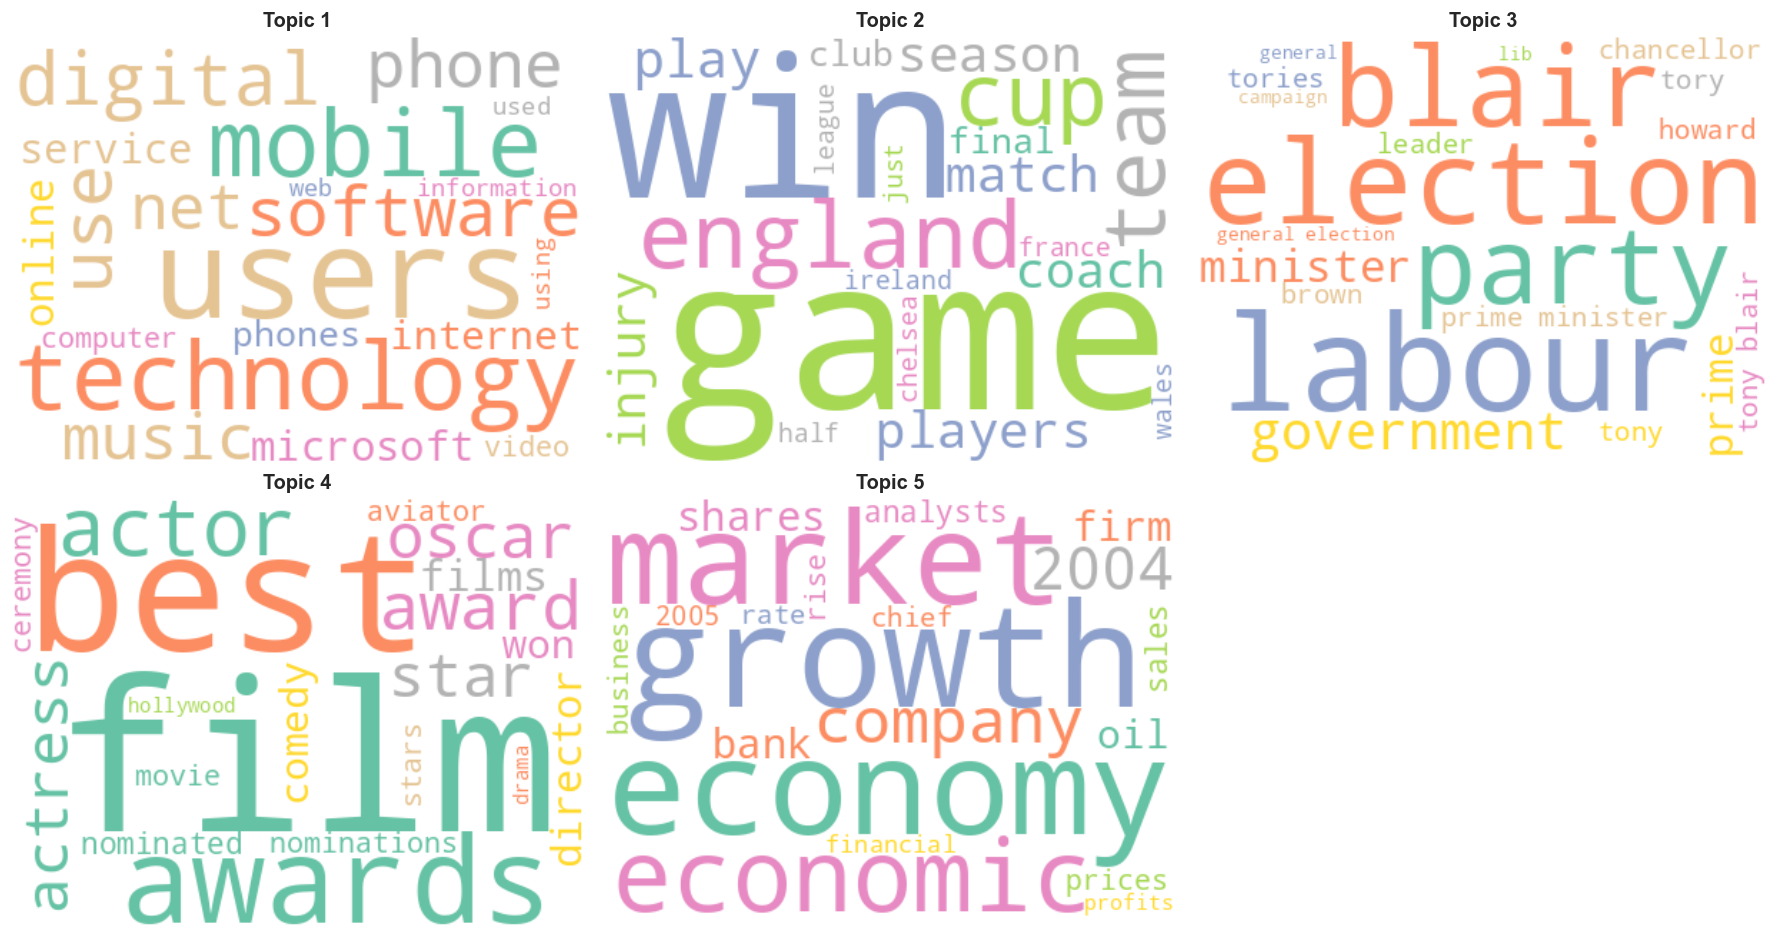

In [15]:
def plot_nmf_topic_clouds(nmf_model, feature_names, num_words=20, filename="nmf_topic_clouds"):
    """
    Plot word clouds for NMF topics
    """
    n_topics = nmf_model.n_components
    H = nmf_model.components_  # Topic-word matrix

    if n_topics <= 6: # will try this with n_components = 10 and n_components = 5
        cols = 3
    else:
        cols = 4

    rows = (n_topics + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten()

    for topic_idx in range(n_topics):
        # Get topic weights for all words
        topic_weights = H[topic_idx]
        # Get top words and their weights
        top_word_indices = topic_weights.argsort()[-num_words:][::-1]

        # Create word frequency dictionary using NMF weights
        word_freq = {}
        for idx in top_word_indices:
            word = feature_names[idx]
            weight = topic_weights[idx]
            # Scale weights for better word cloud visualization
            word_freq[word] = weight * 1000

        # Generate word cloud
        wordcloud = WordCloud(
            width=400,
            height=300,
            background_color='white',
            max_words=num_words,
            colormap='Set2',
            prefer_horizontal=0.7,
            relative_scaling=0.5,
            min_font_size=8
        ).generate_from_frequencies(word_freq)

        # Plot
        axes[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axes[topic_idx].set_title(f'Topic {topic_idx + 1}', fontsize=12, fontweight='bold')
        axes[topic_idx].axis('off')

    # Hide unused subplots
    for i in range(n_topics, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    save_figure(filename)
    plt.show()
    return

plot_nmf_topic_clouds(nmf_model, feature_names, num_words=20, filename="nmf_topic_word_clouds")

The resulting topics seem to align well with the given categories:
1) Technology
2) Sport
3) Politics
4) Entertainment
5) Business

Not surprising, so let's see how these NMF topics can be used as input to classification.


Classification Report:
               precision    recall  f1-score   support

     business       0.95      0.96      0.96       108
         tech       0.91      0.96      0.93        73
     politics       0.96      0.94      0.95        86
        sport       0.94      1.00      0.97       101
entertainment       1.00      0.89      0.94        79

     accuracy                           0.95       447
    macro avg       0.95      0.95      0.95       447
 weighted avg       0.95      0.95      0.95       447

Figure saved: figs/5510_mini_project/nmf_two_confusion_matrix.png


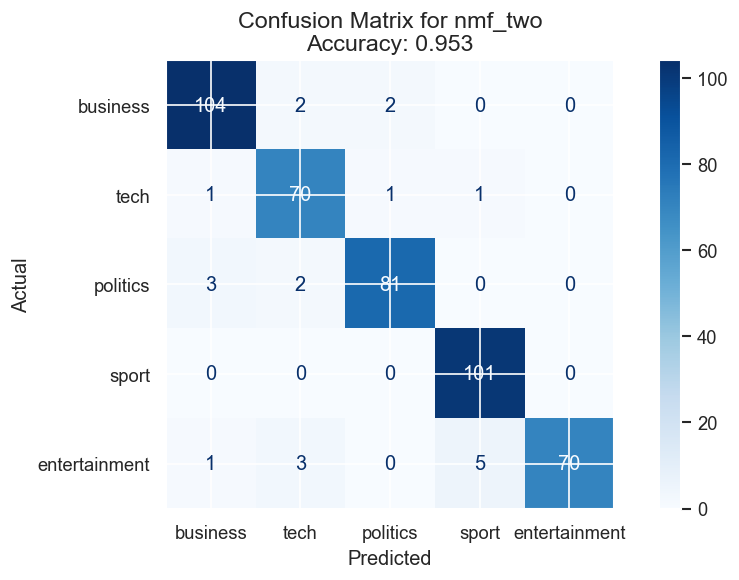


Misclassified articles per category, more than one example:

'politics' predicted as 'business' : 3 examples.

Article 894 (Category: politics):
gurkhas to help tsunami victims britain has offered to send a company of 120 gurkhas to assist with the tsunami relief effort in indonesia  downing street said.  the deployment would involve troops from the 2nd battalion royal gurkha rifles  based in brunei. discussions have begun with indonesia on 
--------------------------------------------------------------------------------

Article 1057 (Category: politics):
minimum wage increased to £5.05 the minimum wage will rise in october  benefiting more than 1m people  the government has announced.  adults must be paid at least £5.05 an hour  up from £4.85  while 18 to 21 year olds will be paid £4.25. the recommendations came from the low pay commission which sai
--------------------------------------------------------------------------------

Article 962 (Category: politics):
hatfield executives

,ArticleId,Text,Predicted_Category LR,Predicted_Category NMF one,Predicted_Category NMF two
0,1018,qpr keeper day heads for preston queens park r...,sport,sport,sport
1,1319,software watching while you work software that...,tech,business,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport,sport,sport
3,459,india s reliance family feud heats up the ongo...,business,business,business
4,1020,boro suffer morrison injury blow middlesbrough...,sport,sport,sport


In [16]:
# Split into train/test using same indices as before
W_train = W[indices_train]
W_test = W[indices_test]

# Train a classifier using topic distributions as features
topic_classifier = LogisticRegression(random_state=SEED)
topic_classifier.fit(W_train, y_train)

y_pred_topics = topic_classifier.predict(W_test)

# Evaluate
accuracy_nmf_two = plot_confusion(y_test, y_pred_topics, name='nmf_two')
# Predict on the actual test data
# have to transform test features using the same NMF model
# Note to self - not fit_transform, because that would be a new model
W_test_full = nmf_model.transform(test_features)
test_predictions = topic_classifier.predict(W_test_full)
test['Predicted_Category NMF two'] = [id_to_category[pred] for pred in test_predictions]
print("\nTest predictions:")
display(test.head())

## 6) Evaluation and Conclusions

Logistic Regression has the best performance evaluated using accuracy. The difference is not huge LR accuracy is 97.5% whereas NMF topic extraction accuracy is 95%.
There are just 34 out of 735 articles where the two methods disagree on classification. (see results below)

Logistic Regression performs better for **classification accuracy** in this case.
- **Optimized for discrimination**: Designed specifically to separate classes
- **All features utilized**: Uses the full TF-IDF feature space
- **Supervised learning**: Benefits from having labeled training data

However, NMF serves a different primary purpose and has several unique advantages for topic extraction:

#### 1. **Interpretability & Explainability**
- **Human-readable topics**: NMF produces clear, interpretable topics with weighted word lists
- **Document composition**: Shows how much each topic contributes to each document
- **Transparency**: You can see exactly why a document belongs to a category based on its topic mixture

#### 2. **Unsupervised Learning**
- **No labels required**: Can discover topics in unlabeled data
- **Exploratory analysis**: Helps understand the structure of your corpus before classification
- **New domain adaptation**: Can find topics in new domains without retraining classifiers

#### 3. **Dimensionality Reduction**
- **Feature compression**: Reduces thousands of TF-IDF features to a handful of meaningful topics
- **Noise reduction**: Filters out less important word combinations
- **Computational efficiency**: Smaller feature space for downstream tasks

#### 4. **Topic Discovery Beyond Categories**
- **Subcategories**: Might discover that "sports" contains distinct topics like "football," "basketball," "Olympics"
- **Cross-category themes**: Could find topics that span multiple categories (e.g., "financial technology")
- **Hidden patterns**: May reveal latent themes not captured by your predefined categories


### **When to Use NMF:**

1. **Content analysis**: Understanding what your documents are actually about
2. **Recommendation systems**: Finding similar documents based on topic similarity
3. **Data exploration**: Before you even know what categories to predict
4. **Feature engineering**: Using topic distributions as features for other models
5. **Anomaly detection**: Finding documents that don't fit well into any topic

NMF is valuable for **understanding** data, while Logistic Regression is better for **predicting** categories. They serve complementary purposes!

In [17]:
print("Comparison of accuracies")
results = [
    ("LogisticRegression", accuracy_logistic_regression),
    ("NMF One", accuracy_nmf_one),
    ("NMF Two", accuracy_nmf_two)
]

max_label_width = max(len(label) for label, _ in results) + 1

for label, accuracy in results:
    print(f"{label:<{max_label_width}}: {accuracy:.3f}")

mask = test['Predicted_Category LR'] != test['Predicted_Category NMF two']
print(f"\nExamples where LR and NMF two disagree:{len(test[mask])}")
display(test[mask].drop(columns=['Predicted_Category NMF one']))

Comparison of accuracies
LogisticRegression : 0.978
NMF One            : 0.843
NMF Two            : 0.953

Examples where LR and NMF two disagree:34


,ArticleId,Text,Predicted_Category LR,Predicted_Category NMF two
39,2167,us to raise tv indecency fines us politician...,entertainment,business
55,1193,eu rules won t stop uk spending the shape of...,politics,business
77,1580,voters flock to blog awards site voting is und...,tech,entertainment
83,349,rapper 50 cent ends protege feud rapper 50 cen...,entertainment,sport
102,1732,crossrail link to get go-ahead the £10bn cro...,politics,business
120,2123,spider-man creator wins profits spider-man cre...,entertainment,business
137,1782,game firm holds cast auditions video game fi...,tech,sport
144,1476,nhs waiting time target is cut hospital waitin...,politics,business
159,483,losing yourself in online gaming online role p...,tech,sport
165,1983,the gaming world in 2005 if you have finished ...,tech,sport


## 7) NMF - n_components as a tunable hyperparameter
Seeing as we use NMF primarily in an unsupervised scenario, I wondered how you tune the number of topics it generates. There is no target variable against which to evaluate accuaracy. After some research and with the assistance of the AI Assistant in Pycharm, I discovered a number of potential approaches:
1) Reconstruction error
2) Silhoutte Score
3) Coherence Score
4) Perplexity

### Summary of guidelines found for choosing n_components:
1. **Domain Knowledge**: Start with the expected number of topics based on domain understanding
2. **Elbow Method**: Look for the "elbow" in reconstruction error plots
3. **Interpretability**: Choose a number where topics remain interpretable and distinct
4. **Stability**: Run multiple times with different random seeds - good n_components should give consistent topics

First, I tried to use the elbow method & reconstruction error to find the best number of topics.

What I found was a fairly smooth descent all the way to n_components = 30. This proved true, even after varying the error statistic I used (see below). So in the end I stuck with n_components = 5.

Figure saved: figs/5510_mini_project/nmf_reconstruction_error.png


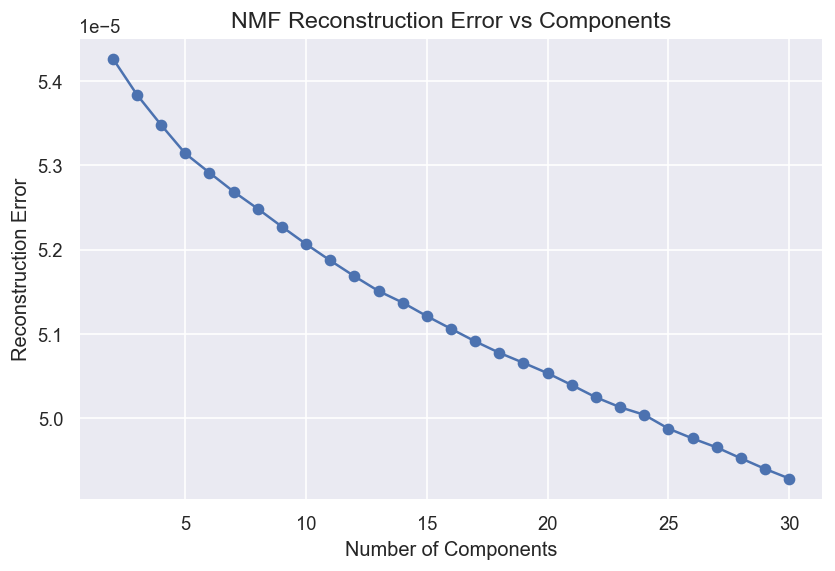

In [18]:
def evaluate_nmf_components(X, component_range):
    reconstruction_errors = []

    for n_comp in component_range:
        nmf = NMF(
            n_components=n_comp,
            random_state=SEED,
            max_iter=1000,
            alpha_W=0.0,  # No regularization initially
            alpha_H=0.0,
            init='nndsvd',
            solver='cd'  # Try coordinate descent solver
        )

        W = nmf.fit_transform(X)
        H = nmf.components_

        # Reconstruct original matrix
        X_reconstructed = W @ H

        # Calculate reconstruction error
        error = mean_squared_error(X.toarray(), X_reconstructed)
        reconstruction_errors.append(error)

    return reconstruction_errors

max_components = 30
component_range = range(2, max_components + 1)
errors = evaluate_nmf_components(features, component_range)
# Plot using reconstruction_error to find elbow point
plt.plot(component_range, errors, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('NMF Reconstruction Error vs Components')
save_figure('nmf_reconstruction_error')
plt.show()


Perhaps altering the error metric can reveal something about optimal n_components.

However, the charts offer nothing new to convince me that altering n_components helps here.

In [19]:
def evaluate_nmf_comprehensive(X, component_range):
    results = {
        'reconstruction_error': [],
        'frobenius_norm': [],
        'explained_variance': []
    }

    X_dense = X.toarray()
    total_variance = np.var(X_dense)

    for n_comp in component_range:
        nmf = NMF(n_components=n_comp, random_state=SEED, max_iter=1000)
        W = nmf.fit_transform(X)
        H = nmf.components_

        X_reconstructed = W @ H

        # Multiple metrics
        mse = mean_squared_error(X_dense, X_reconstructed)
        frobenius = np.linalg.norm(X_dense - X_reconstructed, 'fro')
        explained_var = 1 - (np.var(X_dense - X_reconstructed) / total_variance)

        results['reconstruction_error'].append(mse)
        results['frobenius_norm'].append(frobenius)
        results['explained_variance'].append(explained_var)

    return results

results = evaluate_nmf_comprehensive(features, component_range)
results_df = pd.DataFrame(results)
display(results_df)

,reconstruction_error,frobenius_norm,explained_variance
0,0.000054,37.980920,0.025115
1,0.000054,37.830304,0.032838
2,0.000053,37.704158,0.039285
3,0.000053,37.584699,0.045374
4,0.000053,37.504093,0.049486
5,0.000053,37.424528,0.053526
6,0.000052,37.352339,0.057190
7,0.000052,37.276611,0.061019
8,0.000052,37.202903,0.064738
9,0.000052,37.133355,0.068244


Figure saved: figs/5510_mini_project/nmf_comprehensive_evaluation.png


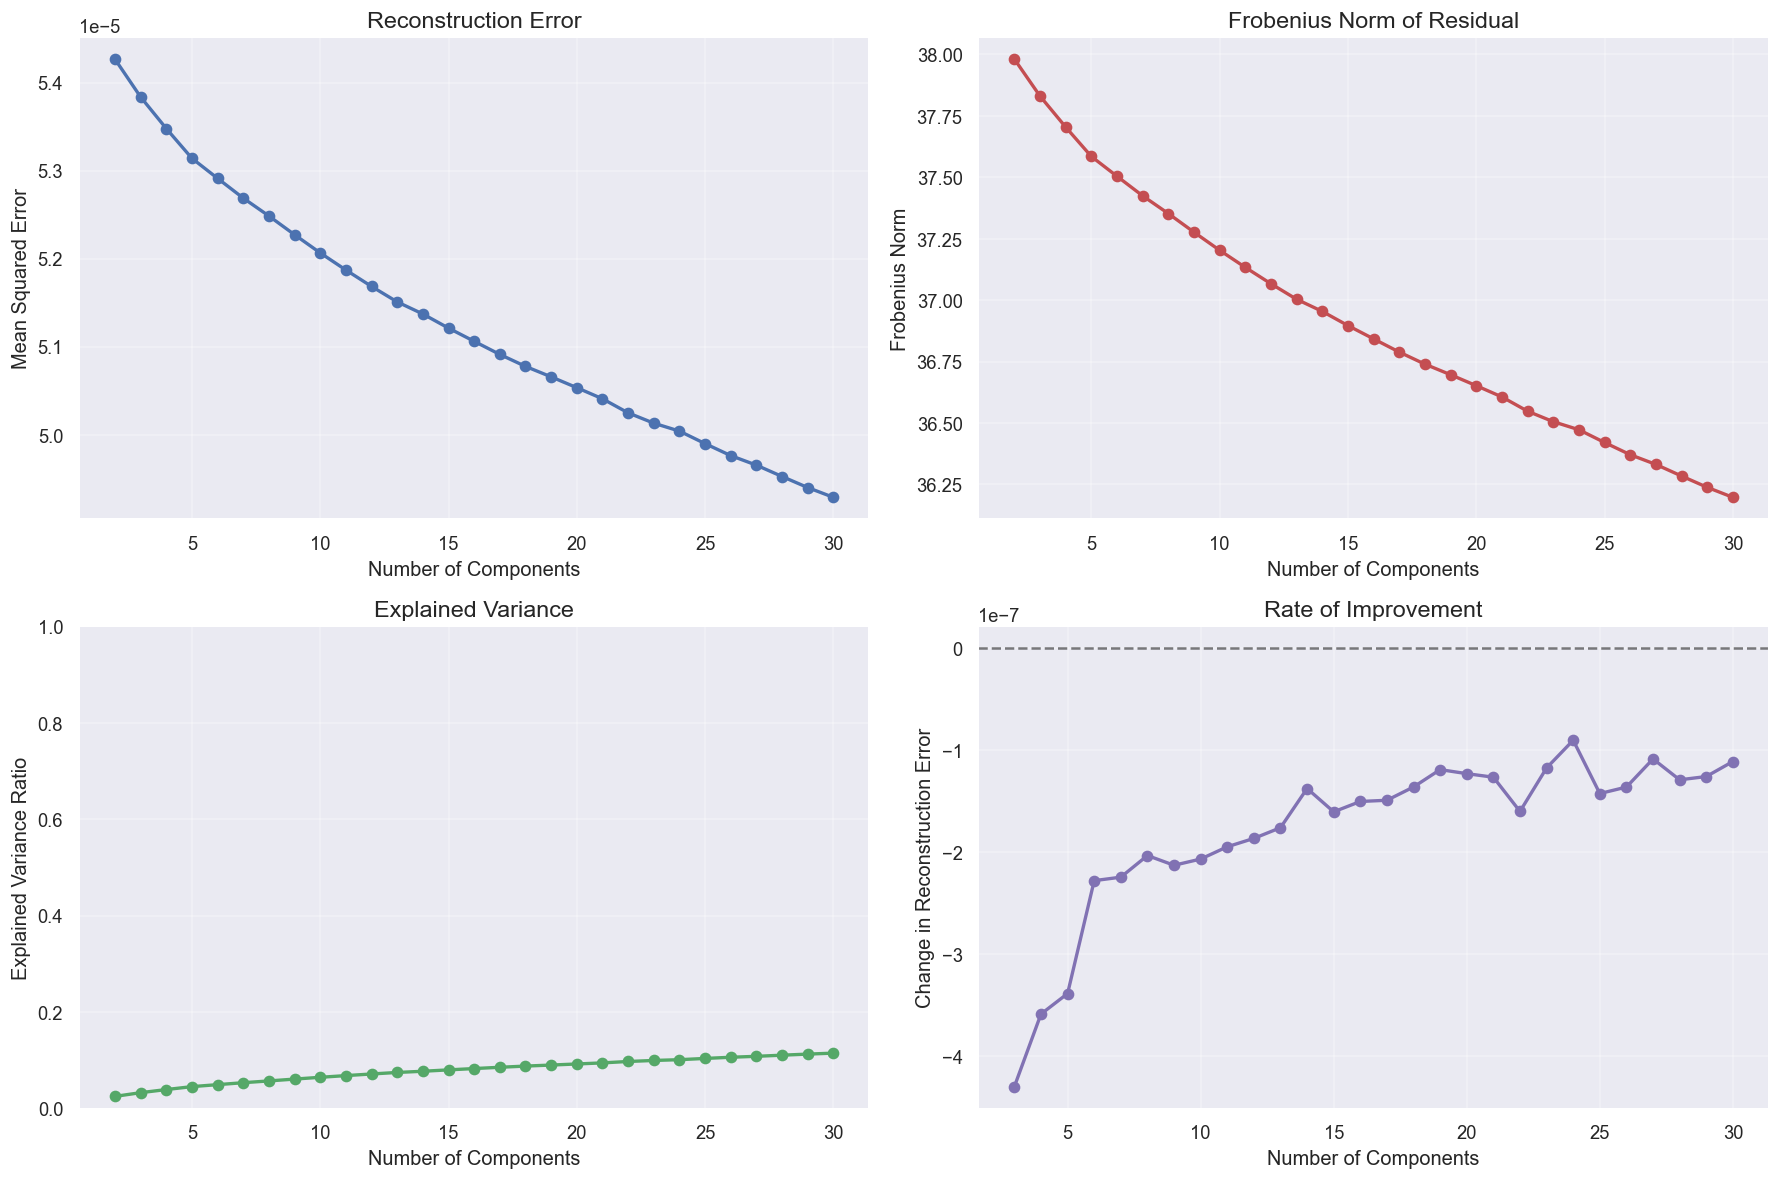


Summary Statistics:
Best Reconstruction Error: 0.000049 at 30 components
Best Frobenius Norm: 36.197524 at 30 components
Best Explained Variance: 0.1149 at 30 components
Potential elbow point: 17 components


In [20]:
def plot_nmf_comprehensive_results(component_range, results, save_name='nmf_comprehensive_evaluation'):
    """
    Plot comprehensive NMF evaluation metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Reconstruction Error
    axes[0, 0].plot(component_range, results['reconstruction_error'], 'bo-', linewidth=2, markersize=6)
    axes[0, 0].set_xlabel('Number of Components')
    axes[0, 0].set_ylabel('Mean Squared Error')
    axes[0, 0].set_title('Reconstruction Error')
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Frobenius Norm
    axes[0, 1].plot(component_range, results['frobenius_norm'], 'ro-', linewidth=2, markersize=6)
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('Frobenius Norm')
    axes[0, 1].set_title('Frobenius Norm of Residual')
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Explained Variance
    axes[1, 0].plot(component_range, results['explained_variance'], 'go-', linewidth=2, markersize=6)
    axes[1, 0].set_xlabel('Number of Components')
    axes[1, 0].set_ylabel('Explained Variance Ratio')
    axes[1, 0].set_title('Explained Variance')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim(0, 1)  # Explained variance is between 0 and 1

    # Plot 4: Rate of Change in Reconstruction Error
    if len(results['reconstruction_error']) > 1:
        error_diff = np.diff(results['reconstruction_error'])
        axes[1, 1].plot(component_range[1:], error_diff, 'mo-', linewidth=2, markersize=6)
        axes[1, 1].set_xlabel('Number of Components')
        axes[1, 1].set_ylabel('Change in Reconstruction Error')
        axes[1, 1].set_title('Rate of Improvement')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

    plt.tight_layout()

    if save_name:
        save_figure(save_name)

    plt.show()

    # Print some summary statistics
    print(f"\nSummary Statistics:")
    print(f"Best Reconstruction Error: {min(results['reconstruction_error']):.6f} at {component_range[np.argmin(results['reconstruction_error'])]} components")
    print(f"Best Frobenius Norm: {min(results['frobenius_norm']):.6f} at {component_range[np.argmin(results['frobenius_norm'])]} components")
    print(f"Best Explained Variance: {max(results['explained_variance']):.4f} at {component_range[np.argmax(results['explained_variance'])]} components")

    # Find potential elbow points using rate of change
    if len(results['reconstruction_error']) > 2:
        error_diff = np.diff(results['reconstruction_error'])
        second_diff = np.diff(error_diff)

        # Find where the rate of change starts to level off
        # Look for the point where second derivative is closest to zero
        if len(second_diff) > 0:
            elbow_idx = np.argmin(np.abs(second_diff)) + 2  # +2 due to diff operations
            if elbow_idx < len(component_range):
                elbow_components = component_range[elbow_idx]
                print(f"Potential elbow point: {elbow_components} components")

# Usage:
plot_nmf_comprehensive_results(component_range, results)